# 🌐 Wikipedia recommender system
- Zuzanna Gawrysiak 148255
- Agata Żywot 148258

### Description (straight from ekursy - to be deleted later)


The general task is to create a system that will recommend similar articles based on the previously visited articles.

**Input - Collection of articles (links or titles), Output - Collection of recommended articles (links or titles) with a "score"**


You will receive a grade for each of the following steps. The highest possible score without
finishing all parts is 4.0. For example, if you do perfectly the first two steps your grades will be 4.0,
4.0, 2.0.


**Crawling and scraping** - Download text from at least 1000 Wikipedia/fandom wiki articles.
(Scrappy is not a must)


**Stemming, lemmatization** - preprocess downloaded documents into the most suitable form for this
task. Store it as a .csv/parquet file or into a database.


**Similarities** - for a given collection of previously visited articles find the best matches in your
database and recommend them to the user


GUI not required, notebook or any other reasonable form will be accepted. I have to be able to
provide a list of articles in an easy way and receive a meaningful recommendation.
You have to send the source code and report.


Report:
- pdf or notebook
- explain each step of your algorithm, especially how you score articles
- present interesting statistics about your database (most frequent words, histograms, similarities
between documents, ...)
- show some examples of recommendations with explanations (I'd prefer graphical form - see
prediction breakdowns for example)

## Import necessary libraries

In [ ]:
%pip install pyldavis
%pip install wikipedia

In [2]:
# SCRAPPING
import random
import linecache
import wikipedia
import re
import json

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.sklearn

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agata\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scraping wikipedia articles

In [ ]:
N = 100
with open(r'./data/titles.txt', 'r') as fp:
    num_lines = sum(1 for line in fp)
    # print('Total lines:', num_lines) 

In [ ]:
# get N article titles
random.seed(2137)
line_numbers = random.sample(range(1, num_lines), N)

titles = []
for i in line_numbers:
    x = linecache.getline(r'./data/titles.txt', i).strip()
    titles.append(x)
print(titles[:5])

In [ ]:
def save_titles_content(titles):
    """
    Create JSON files with all page information necessary
    """
    for title in titles:
        try: 
            page = wikipedia.page(title)
        except:
            print(f'No page of title {title}!')
            continue 
        d = dict()
        d['title'] = page.title
        d['url'] = page.url
        d['body'] = re.sub(r'==.*?==+', '', page.content)
        d['links'] = page.links
        try: 
            d['images'] = page.images
        except:
            d['images'] = ''
         
        json_object = json.dumps(d, indent=2)
        file_title = re.sub(r'[\s]','_', page.title)
        file_title = re.sub(r'[,.-]','', file_title)
        
        with open(f'./data/pages_content/{file_title}.json', 'w') as outfile:
            outfile.write(json_object)

In [ ]:
save_titles_content(titles)

In [3]:
# example - to be deleted
f = open('./data/pages_content/Intel.json')
data = json.load(f)
data['body'][:1000]

"Intel Corporation is an American multinational corporation and technology company headquartered in Santa Clara, California. It is the world's largest semiconductor chip manufacturer by revenue, and is one of the developers of the x86 series of instruction sets, the instruction sets found in most personal computers (PCs). Incorporated in Delaware, Intel ranked No. 45 in the 2020 Fortune 500 list of the largest United States corporations by total revenue for nearly a decade, from 2007 to 2016 fiscal years.Intel supplies microprocessors for computer system manufacturers such as Acer, Lenovo, HP, and Dell. Intel also manufactures motherboard chipsets, network interface controllers and integrated circuits, flash memory, graphics chips, embedded processors and other devices related to communications and computing.\nIntel (integrated and electronics) was founded on July 18, 1968, by semiconductor pioneers Gordon Moore (of Moore's law) and Robert Noyce (1927–1990), and is associated with the 

## Stemming, lemmatization

In [6]:
def preprocess(article):
    """
    Tokenize given article, remove stopwords, numbers, then perform stemming
    """
    preprocessed = []
    porter = PorterStemmer()
    tokenized = word_tokenize(article)
    sw = stopwords.words('english')

    for word in tokenized:
        if word.isalpha() and word not in sw:
            preprocessed.append(porter.stem(word)) # stemming is faster than lematization, but has lower accuracy (can try both later)
    return ' '.join(preprocessed)

In [7]:
text = """Poznań University of Technology, PUT (Polish name: Politechnika Poznańska) is a university in Poznań, 
Poland. Poznań University of Technology is known as one of the best technical universities in Poland. URAP 
ranked PUT as in top 6% of world universities and Webometrics ranked it at no. 842 in the world by Google 
citations for the year 2015. In 1995 it became the first Polish university to become a member of the Conference 
of European Schools for Advanced Engineering Education and Research (CESAER), an organization comprising the best 
technical universities in Europe. The university is also a member of the Socrates-Erasmus programme for exchange 
students from all over Europe, promoting advanced engineering and a European dimension. The university is home to 
many organizations and student circles, and the radio station Afera 98.6 MHz. The university has over 
21,000 students and over 1100 academic staffs.""".replace('\n',' ')
text2 = "TFIDF (term frequency–inverse document frequency) is a much better approach. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general."
text3 = "This tradition dates back to pagan times, when during the autumn feast the gods were offered sacrifices of oxen or, as a substitute, of dough rolled up in oxen horns. The Latin Church has taken over this custom and linked it to the figure of St Martin. The shape of the dough was interpreted as a reference to the horseshoe that the holy horse was to lose. In Poznań, the tradition of baking 'rogal świętomarciński' on 11 November certainly existed in 1860, when the oldest known advertisement for the rogal świętomarciński was published in Dziennik Poznański."

In [8]:
articles = pd.DataFrame([["PUT", text],
                        ["bla bla", text2],
                         ["rogal", text3]],
                         columns = ['URL','body'])

for a in articles.body:
    articles = articles.replace(a, preprocess(a))
articles

,URL,body
0,PUT,poznań univers technolog put polish name polit...
1,bla bla,tfidf term document frequenc much better appro...
2,rogal,thi tradit date back pagan time autumn feast g...


### Count vector
Store articles as numbers of occurences of words.

In [9]:
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
CountData = CountVec.fit_transform(articles.body)
 
CountData
# if dataset is too large, try: https://scikit-learn.org/stable/modules/feature_extraction.html#vectorizing-a-large-text-corpus-with-the-hashing-trick 

<3x106 sparse matrix of type '<class 'numpy.int64'>'
	with 109 stored elements in Compressed Sparse Row format>

In [10]:
dfCV = pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out(), index=articles.URL)
dfCV

,academ,adjust,advanc,advertis,afera,appear,approach,autumn,bake,becam,...,time,tradit,univers,urap,valu,webometr,word,world,year,świętomarciński
URL,,,,,,,,,,,,,,,,,,,,,
PUT,1,0,2,0,1,0,0,0,0,1,...,0,0,10,1,0,1,0,2,1,0
bla bla,0,1,0,0,0,2,1,0,0,0,...,1,0,0,0,1,0,3,0,0,0
rogal,0,0,0,1,0,0,0,1,1,0,...,1,2,0,0,0,0,0,0,0,2


## Database analysis
> present interesting statistics about your database (most frequent words, histograms, similarities between documents, ...)

### Most frequent words

Top five most frequent words:
univers     10
poznań       4
student      3
document     3
word         3
dtype: int64


<AxesSubplot:title={'center':'Most frequent words'}>

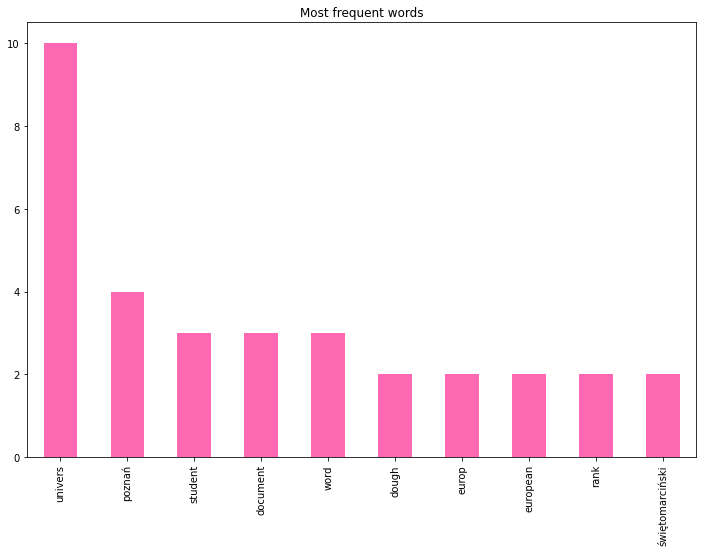

In [11]:
word_sums = dfCV.sum(axis=0)
word_sums = word_sums.sort_values(ascending=False)
print(f"Top five most frequent words:\n{word_sums[:5]}")
word_sums[:10].plot(kind='bar', figsize=(12,8), title="Most frequent words", color='hotpink')

All words as a wordcloud

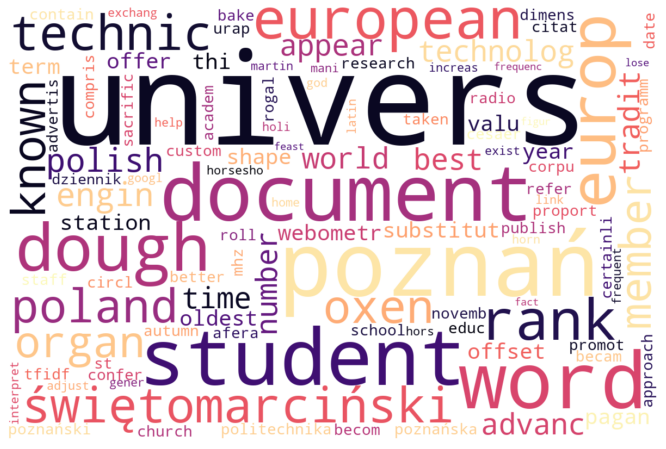

In [12]:
def generate_wordcloud(data):
    wc = WordCloud(width=1200, height=800, max_words=150, background_color='white', colormap='magma').generate_from_frequencies(data)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_wordcloud(word_sums)

### Similarities between documents

Check the similarities using LDA (Latent Drichlet Allocation). 

In [13]:
lda_tf = LatentDirichletAllocation(n_components=3, random_state=0) # number of articles
lda_tf.fit(CountData)

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf, CountData, CountVec, mds='tsne')
panel

c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\ag

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  48.958920
0      -387.996002  -373.316162       2        1  32.409976
1     -2184.745605   -60.565800       3        1  18.631104, topic_info=         Term      Freq     Total Category  logprob  loglift
98    univers  7.000000  7.000000  Default  30.0000  30.0000
102      word  1.000000  1.000000  Default  29.0000  29.0000
25   document  1.000000  1.000000  Default  28.0000  28.0000
5      appear  1.000000  1.000000  Default  27.0000  27.0000
59     number  1.000000  1.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
23       date  0.144487  1.128065   Topic3  -5.2310  -0.3747
27   dziennik  0.144487  1.128065   Topic3  -5.2310  -0.3747
33      exist  0.144487  1.128065   Topic3  -5.2310  -0.3747
50      known  0.144510  1.795664   Topic3  -5.2308  -0.8394
69     poznań  0.144508  3.131078   Topic3  -5.2308  -1.3955

[125 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
0         1  0.816412           academ
1         3  1.009423           adjust
2         1  1.056806           advanc
3         2  0.886474         advertis
4         1  0.816412            afera
...     ...       ...              ...
98        1  0.967724          univers
100       3  1.009423             valu
102       3  0.538382             word
103       1  1.056806            world
105       2  0.588627  świętomarciński

[87 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

### Conclusions from analysis
* the most frequent word is ...
* bla bla

## TFIDF approach
Count vector was for showing some interesteing statistics, but for the recommendation we will use TFIDF.

In [14]:
tfidf = TfidfVectorizer(ngram_range=(1,1), use_idf=True, smooth_idf=False, stop_words='english') 
tfidf_data = tfidf.fit_transform(articles.body) 
dfTFIDF = pd.DataFrame(tfidf_data.toarray(), index=articles.URL, columns=tfidf.get_feature_names_out())
dfTFIDF

,academ,adjust,advanc,advertis,afera,appear,approach,autumn,bake,becam,...,time,tradit,univers,urap,valu,webometr,word,world,year,świętomarciński
URL,,,,,,,,,,,,,,,,,,,,,
PUT,0.071891,0.000000,0.143783,0.000000,0.071891,0.000000,0.000000,0.000000,0.000000,0.071891,...,0.000000,0.00000,0.718913,0.071891,0.000000,0.071891,0.000000,0.143783,0.071891,0.00000
bla bla,0.000000,0.153486,0.000000,0.000000,0.000000,0.306972,0.153486,0.000000,0.000000,0.000000,...,0.102791,0.00000,0.000000,0.000000,0.153486,0.000000,0.460458,0.000000,0.000000,0.00000
rogal,0.000000,0.000000,0.000000,0.136915,0.000000,0.000000,0.000000,0.136915,0.136915,0.000000,...,0.091694,0.27383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.27383


Save the obtained data frame to csv file.

In [15]:
dfTFIDF.to_csv('articles.csv')

## Similarities

In [16]:
query = "poznań"
query = preprocess(query)
query = tfidf.transform([query]).toarray()[0] 
1-dfTFIDF.apply(lambda x: cosine(x, query), axis=1).sort_values()

URL
PUT        0.144439
rogal      0.091694
bla bla    0.000000
dtype: float64